In [5]:
import numpy as np
def read_data(file):
    data=[]
    with open(file,'r',encoding='utf-8') as f:
        for line in (f.readlines()):
            line = line.strip().replace(' ', '')
            data.append(line)
    return data
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook_source__.ipynb


In [2]:
data=read_data("/kaggle/input/dataset/clr_conversation.txt")
print(len(data))
data[:5]

2842478


['美國2500萬名老兵致敬', '我尤其高興能回到家鄉', '對我家裡的兩名老兵致敬', '家父,前任參議員亨利謝登', '和我弟弟華利謝登']

In [2]:
def load_dictionary(vocab_name):
    print ('loading dictionary')
    vocab, rev_vocab = {}, {}
    with open(vocab_name, 'r',encoding='utf-8') as fin:
        for line in fin:
            i, w = line.strip().split()
            vocab[str(w)] = int(i)
            rev_vocab[int(i)] = str(w)
    return vocab,rev_vocab
vocab,rev_vocab=load_dictionary('/kaggle/input/dataset/vocab.txt')
print(len(vocab))

loading dictionary
3000


In [3]:
def sentence_to_id(sentence,vocab):
    return [int(vocab.get(w, vocab.get('<UNK>'))) for w in sentence]

def prepare_text_data(text,max_length,vocab):
        text_id = []
        text_weight = []
      
        for data in text:
            sentence = sentence_to_id(data,vocab)
            if len(sentence) >= max_length:
                text_weight.append(max_length)
                text_id.append(sentence[:max_length]) 
            else:
                text_weight.append(len(sentence)+1)
                text_id.append(sentence + [vocab.get('<PAD>')]*(max_length-len(sentence)))
        text_id = np.asarray(text_id)
        text_weight = np.asarray(text_weight)
        return text_id,text_weight

In [5]:
import tensorflow as tf
x,y=data[:-1],data[1:]
print(x[0],y[0])
x_id,x_weight=prepare_text_data(x,30,vocab)
print(x_id[0])
y_id,y_weight=prepare_text_data(y,30,vocab)
#y_id=np.hstack((np.ones((y_id.shape[0],1)),y_id))
print(y_id[0])
#y_id=tf.one_hot(y_id,3000)

美國2500萬名老兵致敬 我尤其高興能回到家鄉
[ 178  173  249  316  149  149  353  219  151  914 1060 1190    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[   4 1293  232  198  332   41  101   31   87 1423    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [6]:
x=x_id.reshape(-1,30)
decoder_input_seq = y_id[:,:-1].reshape(-1,29)
decoder_target_seq = y_id[:,1:].reshape(-1,29)
#def map_func(a,b):
 #   a = tf.one_hot(a, depth=3000,axis=-1)
 #   b = tf.one_hot(b, depth=3000,axis=-1)
 #   return (a[0],a[1]),b

#dataset_X = tf.data.Dataset.from_tensor_slices((x,decoder_input_seq))
#dataset_label = tf.data.Dataset.from_tensor_slices(decoder_target_seq)

#dataset = tf.data.Dataset.zip((dataset_X, dataset_label))
#training_elements = int(2842478 * 0.99)
#train_dataset= dataset.take(training_elements).batch(128, drop_remainder=True).shuffle(500).map(map_func)

#valid_dataset = dataset.skip(training_elements).batch(128).shuffle(500).map(map_func)

In [7]:
#print(x[0],decoder_input_seq[0],decoder_target_seq[0])

In [10]:
import tensorflow as tf

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
from tensorflow.keras.layers import Embedding,Input,LSTM,TimeDistributed,Embedding,Dense,GRU,Bidirectional

In [11]:
#encoder
enc_input = Input((30,), name = 'encoder_input_seq')
enc_embed = Embedding(len(vocab) + 1, 150, name = 'encoder_embed',mask_zero=True)(enc_input)
hidden = Bidirectional(GRU(100, return_sequences=True, name = 'encoder_hidden'))(enc_embed)
enc_z, enc_state_h, enc_state_c= LSTM(100, name = 'encoder',return_sequences=False,return_state=True)(hidden)

In [12]:
# decoder 
dec_input = Input((None,), name = 'decoder_input_seq')
dec_embed = Embedding(len(vocab) + 1, 150, name = 'decoder_embed',mask_zero=True)(dec_input)
dec_hidden = Bidirectional(GRU(100, return_sequences=True, name = 'decoder_hidden'))
decoder = Bidirectional(GRU(100, return_state=True, return_sequences=True, name = 'decoder'))
timedistributed=TimeDistributed(Dense(len(vocab), activation='softmax'), name = 'decoder_output')
build_all=  dec_hidden(dec_embed,initial_state = [enc_state_h, enc_state_c])
dec_z_all, dec_state_h_all, dec_state_c_all = decoder(build_all)
dec_fc_all = timedistributed(dec_z_all)

In [23]:
enc_dec_model = tf.keras.Model([enc_input, dec_input], dec_fc_all)
enc_dec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["accuracy"])
enc_dec_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_seq (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, 30, 150)      450150      encoder_input_seq[0][0]          
__________________________________________________________________________________________________
decoder_input_seq (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 200)      151200      encoder_embed[0][0]              
____________________________________________________________________________________________

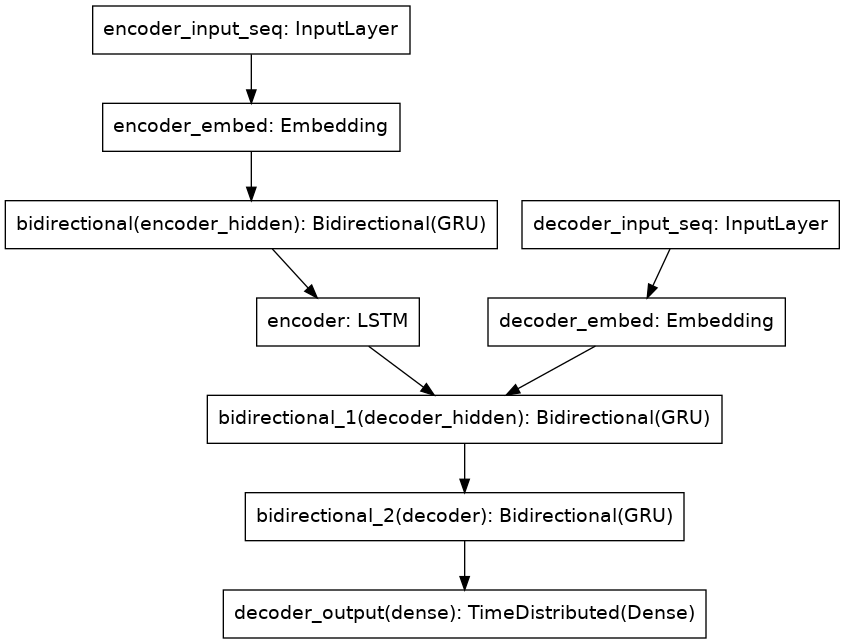

In [24]:
tf.keras.utils.plot_model(enc_dec_model)

In [25]:
#training_elements = int(2842478 * 0.99)
#train_dataset = dataset.take(training_elements)
#validation_dataset = dataset.skip(training_elements)

In [26]:
#train_dataset = train_dataset.batch(256, drop_remainder=True).shuffle(2000)
#validation_dataset = validation_dataset.batch(256)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('checkpoints_every_epoch/model_{epoch:02d}.h5', save_weights_only = False,save_best_only=False)
early_stop=EarlyStopping(monitor='val_accuracy', patience=2,min_delta=0.001)

In [28]:
#for i in train_dataset.take(1):
 #   print(i[0][0].shape,i[0][1].shape,i[1].shape)

#for i in valid_dataset.take(1):
 #   print(i[0][0].shape,i[0][1].shape,i[1].shape)
print(x.shape,decoder_input_seq.shape,decoder_target_seq.shape)

(2842477, 30) (2842477, 29) (2842477, 29)


In [29]:
history = enc_dec_model.fit([x,decoder_input_seq],decoder_target_seq,validation_split=0.01,epochs=20,callbacks=[checkpoint,early_stop])

Epoch 1/20
87940/87940 [==============================] - 5162s 58ms/step - loss: 0.1792 - accuracy: 0.9090 - val_loss: 8.7203e-04 - val_accuracy: 0.9998
Epoch 2/20
87940/87940 [==============================] - 5118s 58ms/step - loss: 4.1407e-04 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 3/20
87940/87940 [==============================] - 4419s 50ms/step - loss: 4.1902e-04 - accuracy: 0.9999 - val_loss: 8.6429e-04 - val_accuracy: 0.9998


In [17]:
enc_dec_model=tf.keras.models.load_model("/kaggle/input/model-1/model_01.h5")

print([i.name for i in enc_dec_model.layers])
enc_model=tf.keras.Model(enc_dec_model.input[0],enc_dec_model.get_layer("encoder").output[1:])
print(enc_model.summary())
dec_input = Input((None,), name = 'decoder_input')
dec_state_h=Input((100,), name = 'init_state_h')
dec_state_c=Input((100,), name = 'init_state_c')
decoder_states_inputs = [dec_state_h, dec_state_c]

embed=enc_dec_model.get_layer("decoder_embed")(dec_input)
h1=enc_dec_model.get_layer('bidirectional_1')(embed,initial_state =decoder_states_inputs)
z,h,c=enc_dec_model.get_layer('bidirectional_2')(h1)
output=enc_dec_model.get_layer('decoder_output')(z)
dec_model=tf.keras.Model([dec_input]+decoder_states_inputs,[output,h,c])

print(dec_model.summary())

['encoder_input_seq', 'encoder_embed', 'decoder_input_seq', 'bidirectional', 'decoder_embed', 'encoder', 'bidirectional_1', 'bidirectional_2', 'decoder_output']
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_seq (InputLaye [(None, 30)]              0         
_________________________________________________________________
encoder_embed (Embedding)    (None, 30, 150)           450150    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 200)           151200    
_________________________________________________________________
encoder (LSTM)               [(None, 100), (None, 100) 120400    
Total params: 721,750
Trainable params: 721,750
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_4"
____________________________________________________________________

In [52]:
#decoder_model.summary()

In [18]:
test_input=read_data("/kaggle/input/dataset-test/test_input.txt")
print(test_input[:10])
test_id,test_weight=prepare_text_data(test_input,30,vocab)
test_id=test_id.reshape(-1,30)
print(test_id)
#print(test_id[0])

['那一點也不難', '如你所知,"癲狂"這東西', '就好比一股引力', '只需小小的推動,人就飄向那裏了', '登特!', '戈登,你的人接走瑞秋之後', '就是把她帶到了這兒', '她就是在這兒死的', '我知道,當時我也在這兒', '想要救她']
[[ 27  14  67 ...   0   0   0]
 [ 80   6  85 ...   0   0   0]
 [ 29  21 177 ...   0   0   0]
 ...
 [674   5  81 ...   0   0   0]
 [ 76 152 351 ...   0   0   0]
 [  4  12  95 ...   0   0   0]]


In [33]:
def decode_sequence_with_greedy_search(input_seq):
    enc_state_h, enc_state_c = enc_model(input_seq)
    h=enc_state_h
    c=enc_state_c
    
    target_seq=np.array([vocab['<BOS>']])
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        y_hat,h,c = dec_model.predict([target_seq]+[h,c])
        print(y_hat[0][-1])
        sampled_token_index = np.argmax(y_hat)
        sampled_char = rev_vocab[sampled_token_index]
        decoded_sentence += sampled_char
  
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '<EOS>' or len(decoded_sentence) > 29:
            stop_condition = True
   
        target_seq=np.array([vocab[sampled_char]])

    return decoded_sentence

In [34]:
print(test_input[0])
decode_sequence_with_greedy_search(test_id[5].reshape(-1,30,1))

那一點也不難
[9.9999928e-01 3.5024650e-11 2.3874989e-11 ... 9.2518443e-10 8.1299993e-12
 8.3343618e-12]
[0.00035896 0.00028711 0.00028741 ... 0.00038021 0.00038492 0.0004121 ]
[2.0058396e-04 1.5556593e-03 1.6096506e-03 ... 7.4105873e-07 3.0142875e-08
 1.2946307e-07]
[1.13104034e-06 1.68760130e-06 1.71336831e-06 ... 8.82772042e-08
 4.42600800e-09 1.08118705e-08]
[2.6094549e-06 7.8426066e-09 7.6167570e-09 ... 4.7594607e-08 1.3358973e-09
 6.4018155e-09]
[4.4936319e-06 1.1794161e-06 1.4297377e-06 ... 4.9485795e-08 7.3462971e-08
 2.8844553e-08]
[5.3727399e-06 4.8823249e-06 5.0430026e-06 ... 1.0604304e-09 6.3019202e-06
 5.5469826e-07]
[5.5350682e-07 2.3958660e-10 2.4538616e-10 ... 2.0382925e-06 2.6342041e-08
 1.5810411e-07]
[1.0448802e-07 3.8759933e-07 3.8532900e-07 ... 5.2483209e-09 2.0349922e-09
 2.7251987e-09]
[7.2286028e-05 8.6331235e-09 9.1914725e-09 ... 1.6453633e-07 6.3595391e-05
 3.8009919e-08]
[5.3959379e-06 1.6477292e-05 2.2113007e-05 ... 4.4301638e-07 1.5685053e-08
 1.8710477e-08]
[1.22

'<PAD>漁丹cDa給厚摩欺不辛戈屈我想養營個捐團騙項溼品莪'

In [35]:
print(test_input[1])
decode_sequence_with_greedy_search(test_id[1].reshape(-1,30,1))

如你所知,"癲狂"這東西
[9.9999976e-01 2.9833875e-11 2.1369351e-11 ... 3.1996958e-10 2.2212208e-12
 5.2561779e-12]
[0.00035896 0.00028711 0.00028741 ... 0.00038021 0.00038492 0.0004121 ]
[2.0058396e-04 1.5556593e-03 1.6096506e-03 ... 7.4105873e-07 3.0142875e-08
 1.2946307e-07]
[1.13104034e-06 1.68760130e-06 1.71336831e-06 ... 8.82772042e-08
 4.42600800e-09 1.08118705e-08]
[2.6094549e-06 7.8426066e-09 7.6167570e-09 ... 4.7594607e-08 1.3358973e-09
 6.4018155e-09]
[4.4936319e-06 1.1794161e-06 1.4297377e-06 ... 4.9485795e-08 7.3462971e-08
 2.8844553e-08]
[5.3727399e-06 4.8823249e-06 5.0430026e-06 ... 1.0604304e-09 6.3019202e-06
 5.5469826e-07]
[5.5350682e-07 2.3958660e-10 2.4538616e-10 ... 2.0382925e-06 2.6342041e-08
 1.5810411e-07]
[1.0448802e-07 3.8759933e-07 3.8532900e-07 ... 5.2483209e-09 2.0349922e-09
 2.7251987e-09]
[7.2286028e-05 8.6331235e-09 9.1914725e-09 ... 1.6453633e-07 6.3595391e-05
 3.8009919e-08]
[5.3959379e-06 1.6477292e-05 2.2113007e-05 ... 4.4301638e-07 1.5685053e-08
 1.8710477e-08]

'<PAD>漁丹cDa給厚摩欺不辛戈屈我想養營個捐團騙項溼品莪'

In [36]:
#test_id[0]

#print(x[0],decoder_input_seq[0])